## analyses in common journeys -unique journey types are excluded from these analyses (doo)
These analyses are in user journeys that took place on GOV.UK in the week 29-10-2018 to 04-11-2018.

doo = 'drop one off'

These analyses are similar to the other PREFIX_journey_eda notebooks but exclude rare journey types which are unique in the week this data was collected

These results are difficult to interpret because the journey type was unique in the timeframe collected but may have been included over a longer timeframe. What does common jounreys mean to people as a denominator. Recommend using the all jounreys notebook instead.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from beakerx import *
from tqdm._tqdm_notebook import tqdm_notebook
from notebook_functions import get_end_page, count_desktop, derive_new_variables, groupby_percent

### Import data

In [2]:
DATADIR = os.path.join(os.getenv("GDRIVE_DATADIR"), 'processed_journey')
DATADIR

'/Volumes/GoogleDrive/Team Drives/GOV.UK teams/2018-2019/Q3/Knowledge up Q3/Data science/data/processed_journey'

In [3]:
#doo=drop one offs
doo = pd.read_csv(os.path.join(DATADIR, "doo_prelim_meta_standard_with_pageseq_from_29-10_to_03-11-2018.csv.gz"), compression='gzip')

In [4]:
#get number of rows, columns
print(doo.shape)

(1722287, 16)


### Sample data for speed

In [5]:
#get a reproducible sample of 1% of journey types from each dataframe, 
#sampled in proportion to the number of occurrences of each journey type
#then join the new samples together into a single dataframe

journeys = doo.sample(frac=0.01, random_state=1234, weights=doo.Occurrences).copy()

In [6]:
#get number of rows, columns in sampled data
journeys.shape

(17223, 16)

In [7]:
#look at distribution of occurrences
journeys['Occurrences'].describe()

count     17223.000000
mean        331.597747
std        4346.523651
min           1.000000
25%           1.000000
50%          11.000000
75%         104.000000
max      313666.000000
Name: Occurrences, dtype: float64

### derive variables (create features...)

In [8]:
journeys = derive_new_variables(journeys).copy()

creating page sequence length vars
Creating search vars
creating final_page_type


### Device used

more_desktop
0    8089
1    9134
dtype: int64


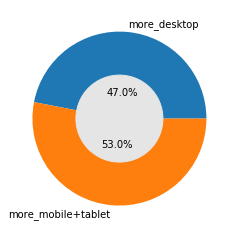

In [9]:
print(journeys.groupby('more_desktop').size())
plt.pie(journeys.groupby('more_desktop').size(), 
        labels=['more_desktop', 'more_mobile+tablet'], 
        autopct='%1.1f%%', 
        pctdistance=0.3)



# add a circle at the center
my_circle=plt.Circle( (0,0), 0.5, color='#E5E5E5')
p=plt.gcf()
p.gca().add_artist(my_circle)

### journey-level data (row per session)

In [10]:
#repeat rows for each occurrence
#make a smaller copy of data with a specific column list (to reduce memory) ready to make it really looooong
slim = journeys[['Occurrences',
                 'final_page',
                 'page_seq_len', 
                 'page_seq_len_NL', 
                 'event_list_contains_start', 
                 'count_search', 
                 'contains_search_regex', 
                 'page_list_NL_eval', 
                 'Page_Seq_NL', 
                 'page_seq_contains_start', 
                 'page_seq_contains_service.gov.uk']].copy()

journey_expanded =  journeys.loc[journeys.index.repeat(journeys['Occurrences'])].copy()

In [11]:
journey_expanded.shape

(5711108, 36)

In [12]:
#There should be a row in journeys_expanded for each occurence in journeys
journeys.Occurrences.sum()

5711108

In [13]:
#Create a variable to identify individual journey types
journey_expanded['journey_type'] = journey_expanded.index

#create a variable to identify individual journeys (can be multiple journeys per journey type if Occurences > 1)
journey_expanded.reset_index(inplace=True)
journey_expanded['journey'] = journey_expanded.index

## Journey length 
Use expanded journeys so the distributions take into account the number of occurences

In [14]:
#this is now the distribution of number of pages in journeys
journey_expanded['page_seq_len'].describe()

count    5.711108e+06
mean     1.279556e+00
std      7.533614e-01
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      3.100000e+01
Name: page_seq_len, dtype: float64

In [15]:
#this is now the distribution of number of pages in journeys where self-loops have been removed
journey_expanded['page_seq_len_NL'].describe()

count    5.711108e+06
mean     1.225655e+00
std      6.959744e-01
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      2.800000e+01
Name: page_seq_len_NL, dtype: float64

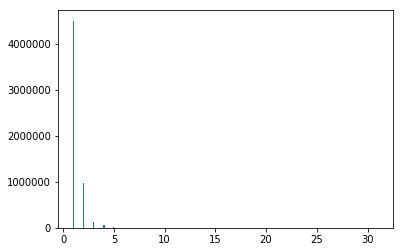

In [16]:
journey_expanded['page_seq_len'].hist(bins=253, grid=False)

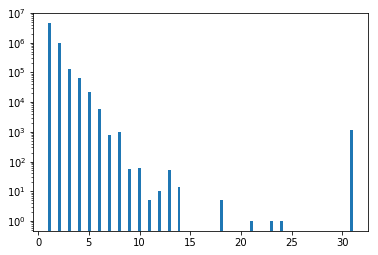

In [17]:
ax = journey_expanded['page_seq_len'].hist(bins=122, grid=False)
ax.set_yscale('log')

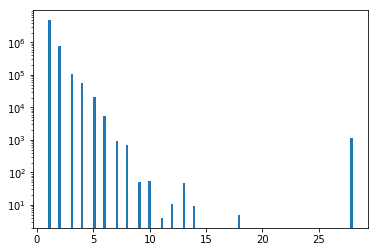

In [18]:
ax = journey_expanded['page_seq_len_NL'].hist(bins=122, grid=False)
ax.set_yscale('log')

## Search

### What proportion of journeys use search, by journey length

In [19]:
print("{}/{} ({}%) of journeys contain internal search in their path".format(journeys['contains_search_n'].sum(),
                                                                             journeys['Page_Seq_Occurrences'].sum(),
                                                                             journeys['contains_search_n'].sum()/journeys['Page_Seq_Occurrences'].sum()*100))

816907.0/373551696.0 (0.21868646528645394%) of journeys contain internal search in their path


find the proportion of journeys which contain search for each journey length.

Do this in journeys (journey-type level) but could do this in journeys to make the deonominator easier to calculate

In [20]:
data = []
for i in range(journeys['page_seq_len'].max()):
    df = journeys[journeys['page_seq_len']==i+1]
    if df['Page_Seq_Occurrences'].sum()>=1:
            percent = round(df['contains_search_n'].sum()/df['Page_Seq_Occurrences'].sum()*100, 1)
            n = df['contains_search_n'].sum()
            denom = df['Page_Seq_Occurrences'].sum()
            p = percent/100
            variance = (p*(1-p))/denom
            data.append([i+1, n, denom, percent, variance])

search_seqlength = pd.DataFrame(data, columns=['length', 'n', 'denom','percent', 'variance'])

In [21]:
search_seqlength.head()

,length,n,denom,percent,variance
0,1,515430.0,332180567.0,0.2,6.008780e-12
1,2,195982.0,36140437.0,0.5,1.376574e-10
2,3,98545.0,2493810.0,4.0,1.539813e-08
3,4,5083.0,1791950.0,0.3,1.669131e-09
4,5,1609.0,835295.0,0.2,2.389575e-09


In [22]:
search_seqlength['length'].describe()

count    19.000000
mean     11.684211
std       8.340348
min       1.000000
25%       5.500000
50%      10.000000
75%      16.000000
max      31.000000
Name: length, dtype: float64

Text(0, 0.5, 'Percent of journeys used internal search')

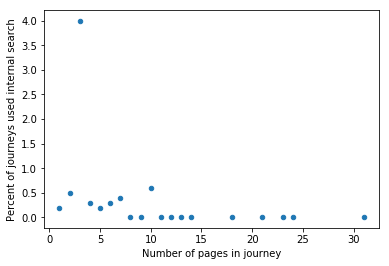

In [23]:
ax = search_seqlength.plot.scatter(x='length', y='percent')
ax.set_xlabel("Number of pages in journey")
ax.set_ylabel("Percent of journeys used internal search")

Text(0, 0.5, 'Percent of journeys used internal search')

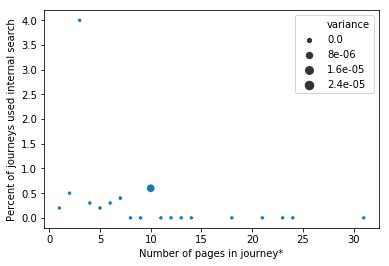

In [24]:
ax = sns.scatterplot(x="length", y="percent", size="variance", data=search_seqlength)
ax.set_xlabel("Number of pages in journey*")
ax.set_ylabel("Percent of journeys used internal search")

### How many times is search used within a single journey

In [25]:
journeys['count_search'].describe()

count    17223.000000
mean         0.025141
std          0.183217
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          4.000000
Name: count_search, dtype: float64

In [26]:
journeys[journeys['contains_search_regex']==1].count_search.describe()

count    367.000000
mean       1.179837
std        0.462030
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        4.000000
Name: count_search, dtype: float64

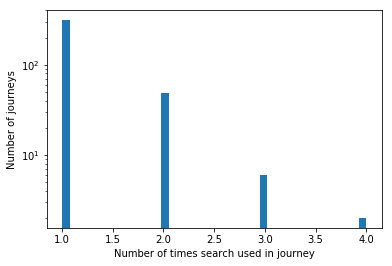

In [27]:
ax = journeys[journeys['contains_search_regex']==1].count_search.hist(bins=40, grid=False)
ax.set_xlabel("Number of times search used in journey")
ax.set_ylabel("Number of journeys")
ax.set_yscale('log')

### How many times is search used within a single journey, by journey length

(0, 312)

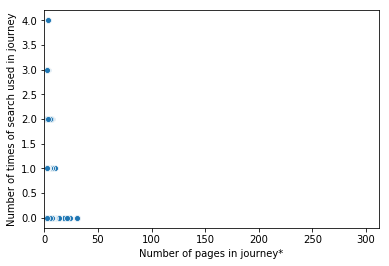

In [28]:
ax = sns.scatterplot(x="page_seq_len", y="count_search", data=journey_expanded)
ax.set_xlabel("Number of pages in journey*")
ax.set_ylabel("Number of times of search used in journey")
ax.set_xlim(0, 312)

## Most visited pages

### Page-level dataframe
Create a page-level dataframe (1 row per page in journey). That's a lot of rows and the df gets huge so it takes while and hammers memory. That's why these sections are commented out so they do not automatically run in a 'run all'

In [29]:
# this gives me a new row for every page in the no loop page list in the data which already has a row for every occurrence

# set up progress bar
tqdm_notebook.pandas(desc='progress creating series...')
# create a pandas series for each page in page sequence, where the index is for each journey 
s = journey_expanded.progress_apply(lambda x: pd.Series(x['page_list_NL_eval']),axis=1)
print("Stacking s")
s = s.stack()
print("resetting index")
s.reset_index(level=1, drop=True, inplace=True)
#Give the series a name attribute
print("Naming series")
s.name = 'page'

KeyboardInterrupt: 

In [ ]:
print("Creating page_expanded using join")
#Add page column to journey, joining on index to expand rows
page_expanded = journey_expanded.join(s).copy()

In [ ]:
page_expanded.head()

### Checking page length in the journey dataframes is consistent with number of rows in page_expanded

In [ ]:
print("Total journeys = {} \nTotal NL journey types = {} \nMean number of journeys per journey type = {}".format(
    journey_expanded.shape[0],
    journey_expanded.Page_Seq_NL.nunique(),
    journey_expanded.shape[0]/journey_expanded.Page_Seq_NL.nunique()))

In [ ]:
#Check consistency in the page_expanded df
print("Total journey made with loops = {} \nTotal journey types = {} \nTotal journey types without loops = {} \nTotal pages visited = {}".format(
    page_expanded.journey.nunique(),
    page_expanded.journey_type.nunique(),
    page_expanded.Page_Seq_NL.nunique(),
    page_expanded.shape[0]))

In [ ]:
total_page_visits = page_expanded.shape[0]

In [ ]:
#this is now the distribution of number of pages in journeys and should match the distribution found in journey_expanded above
page_expanded.groupby(['journey_type', 'journey']).size().describe()

In [ ]:
page_expanded.groupby([ 'journey']).size().describe()

Oh good, this is distribution of number of pages per journey and now matches journey_expanded['page_seq_len_NL'].describe()

### Repeated pages in a journey 

In [ ]:
# So I don't want to have more than one row for a page if it appeared twice in a session.
# I think that's because we might expect pages to be viewed multiple times in a session for both the do-a-thing and chang-a-thing journeys
# So I'm going to drop duplicate rows for a page within the same journey

page_expanded_no_repeats = page_expanded.drop_duplicates(['journey', 'page']).copy()

In [ ]:
print("Total journey made with loops = {} \nTotal journey types = {} \nTotal journey types without loops = {} \nUnique pages visited = {}".format(
    page_expanded_no_repeats.journey.nunique(),
    page_expanded_no_repeats.journey_type.nunique(),
    page_expanded_no_repeats.Page_Seq_NL.nunique(),
    page_expanded_no_repeats.shape[0]))

In [ ]:
print("So there were {} pages that were visited at least once in a journey and won't be counted from now".format(
page_expanded.shape[0]-page_expanded_no_repeats.shape[0]))

In [ ]:
print("The mean number of visits to a single page in a journey ={}".format(
    total_page_visits/page_expanded_no_repeats.shape[0]))

In [ ]:
#This gives the distribution of the number of times the same page was visited in a journey
page_expanded.groupby(['journey', 'page']).size().describe()

Most journeys (>=75%) (without loops) only visit a page once. The average is 1.25 because a small number of jounreys visit a page many times

### Page visit frequency at journey-level
We have a lot of page hit data in Google Analytics but it doesn't take into account repeated hits in the same session. In the following analyses, a page is only counted once in a journey, regardless of how many times it was visited.

In [ ]:
#This gives the distribution of the number of journeys containing a page
page_expanded_no_repeats.groupby([ 'page']).size().describe()

This is the distribution of number of journeys containing a page. Some pages are in lots of journeys (>10000) and half of pages are only in one. The mean number of jounreys a page is in is 859. 

In [ ]:
#These are the topmost represented pages in the journeys we sampled
page_expanded_no_repeats.groupby([ 'page']).size().sort_values(ascending=False).head(20)

In [ ]:
ax = page_expanded_no_repeats.groupby([ 'page']).size().hist(bins=200)
ax.set_yscale('log')

### Volume of content that is most visited in journeys

Using Google analytics, there's a 2% of content is in 80% of sessions result that is used to define mainstream by some people. When you remove repeated visits per session, what's the relationship between frequency of page visits and cumulative volume of content

In [ ]:
print("There are {} different pages".format(
    page_expanded_no_repeats.groupby([ 'page']).size().sort_values(ascending=False).shape[0]))

unique_pages = page_expanded_no_repeats.groupby([ 'page']).size().sort_values(ascending=False).shape[0]

In [ ]:
top_2_percent = page_expanded_no_repeats.groupby([ 'page']).size().nlargest(int(unique_pages * 0.02))

In [ ]:
print("the top 2% of pages are visited in {}% of journeys".format(
    top_2_percent.sum()/page_expanded_no_repeats.groupby([ 'page']).size().sum()))

In [ ]:
percent = 0.13

print("the top {}% of pages are visited in {}% of journeys".format(
    percent * 100,
    page_expanded_no_repeats.groupby([ 'page']).size().nlargest(int(unique_pages * percent)).sum()/page_expanded_no_repeats.groupby([ 'page']).size().sum()))

In [ ]:
data = []
for i in tqdm_notebook(np.arange(0.0, 1.0, 0.01)):
    percent_of_pages = i*100
    n = page_expanded_no_repeats.groupby([ 'page']).size().nlargest(int(unique_pages * i)).sum()
    percent_of_journeys = n/page_expanded_no_repeats.groupby([ 'page']).size().sum()*100
    data.append([percent_of_pages, n, percent_of_journeys])

journey_to_content_relationship = pd.DataFrame(data, columns=['percent_of_pages', 'number_of_pages', 'percent_of_journeys'])

In [ ]:
ax = sns.scatterplot(x="percent_of_pages", y="percent_of_journeys", data=journey_to_content_relationship)
ax.set_xlabel("Percent of pages in data")
ax.set_ylabel("Percent of journeys containing these pages")


# Create a Rectangle patch
rect = patches.Rectangle((0,0),
                         2,
                         top_2_percent.sum()/page_expanded_no_repeats.groupby([ 'page']).size().sum()*100,
                         linewidth=1,edgecolor='r',
                         facecolor='red', 
                         fill=True, 
                         alpha=0.5
                        )
# rect2 = patches.Rectangle((0,0),13,84,linewidth=1,edgecolor='blue',facecolor='blue', fill=True, alpha=0.05)
# Add the patch to the Axes
ax.add_patch(rect)
# ax.add_patch(rect2)

In [ ]:
# ax = sns.scatterplot(x="percent_of_pages", y="percent_of_journeys", data=journey_to_content_relationship)
# ax.set_xlabel("Percent of pages in data")
# ax.set_ylabel("Percent of journeys containing these pages")
# ax.set_xlim(0, 20)

# # Create a Rectangle patch
# rect = patches.Rectangle((0,0),2,66,linewidth=1,edgecolor='r',facecolor='red', fill=True, alpha=0.5)

# # Add the patch to the Axes
# ax.add_patch(rect)

### journeys containing start pages

In [ ]:
journey_expanded.event_list_contains_start.value_counts()

In [ ]:
journey_expanded.event_list_contains_start.value_counts(normalize=True)

In [ ]:
journey_expanded.page_seq_contains_start.value_counts()

In [ ]:
journey_expanded.page_seq_contains_start.value_counts(normalize=True)

In [ ]:
plt.pie(journey_expanded.event_list_contains_start.value_counts(), 
        labels=['start not in event list', 'the word start is in event list'], 
        autopct='%1.1f%%', 
        pctdistance=0.3)

# add a circle at the center
my_circle=plt.Circle( (0,0), 0.5, color='#E5E5E5')
p=plt.gcf()
p.gca().add_artist(my_circle)

In [ ]:
plt.pie(journey_expanded.page_seq_contains_start.value_counts(), 
        labels=['start not in journey sequence', 'the word start is in journey sequence'], 
        autopct='%1.1f%%', 
        pctdistance=0.3)

# add a circle at the center
my_circle=plt.Circle( (0,0), 0.5, color='#E5E5E5')
p=plt.gcf()
p.gca().add_artist(my_circle)

### Identifying journeys that go to service
the domain service.gov.uk identifies only those services which has passed a service assessment and therefore does not include legacy services or those hosted on other domains for different reasons.

In [ ]:
plt.pie(journey_expanded['page_seq_contains_service.gov.uk'].value_counts(), 
        labels=['not in journey sequence', 'service.gov.uk is in journey sequence'], 
        autopct='%1.1f%%', 
        pctdistance=0.3)

# add a circle at the center
my_circle=plt.Circle( (0,0), 0.5, color='#E5E5E5')
p=plt.gcf()
p.gca().add_artist(my_circle)

### End/final page as a proxy for 'destination'

In [ ]:
print("There are {} different 'destination' pages in the sample. I used quotes because there are a few too many assumptions here to be sure"
      " that the final page was the intended destination so...".format(journeys['final_page'].nunique()))

#### most frequent end pages

In [ ]:
journey_expanded.groupby('final_page').size().describe()

In [ ]:
journey_expanded.groupby('final_page').size().sort_values(ascending=False)

You can compare the most frequent 'destination' pages with the most frequently visited pages (at journey-level), that are listed above

In [ ]:
ax = journey_expanded.groupby('final_page').size().hist(bins=50, grid=False)
ax.set_yscale('log')
ax.set_ylabel("log(frequency)")
ax.set_xlabel("Number of journeys where page is final")

### Most number of 'ways' of getting there

In [ ]:
print("On average there are {} journeys per exit page; ways of getting there".format(journeys.shape[0]/journeys['final_page'].nunique()))

In [ ]:
unique_page_sequences = journeys.drop_duplicates('Page_Seq_NL')

In [ ]:
unique_page_sequences.groupby('final_page').size().describe()

In [ ]:
unique_page_sequences.groupby('final_page').size().sort_values(ascending=False)

In [ ]:
#Vehicle tax has a pretty diverse set of paths to it. Let's have a little look
pd.set_option('display.max_colwidth', -1)
unique_page_sequences[unique_page_sequences['final_page']=='/vehicle-tax'].head()

In [ ]:
#This variable is defined from keywords within the final page that might give a clue to what the page does
journeys.groupby('final_page_type').size()

In [ ]:
#Here's the percentage distribution
groupby_percent(journeys, 'final_page_type', 'Page_Seq_NL')

## Final interaction with GOV.UK

In [ ]:
# what do 'start' at end of journey look like?
journeys[journeys.final_interaction.str.contains('start')]

In [ ]:
#What's the number of final pages that go to an e=assessed service. 
plt.pie(journey_expanded['exit_to_assessed_service'].value_counts(), 
        labels=['did not exit to an assessed service', 'exited to an assessed service'], 
        autopct='%1.1f%%', 
        pctdistance=0.3)

# add a circle at the center
my_circle=plt.Circle( (0,0), 0.5, color='#E5E5E5')
p=plt.gcf()
p.gca().add_artist(my_circle)

that's a bit lower than those containing a service.gov.uk anywhere in the journey (37%) which is what you'd expect...

In [ ]:
groupby_percent(journeys, 'final_interaction_type', 'PageSequence', figsize=(5, 10))

In [ ]:
journeys.groupby('final_interaction_type').size().sort_values(ascending=False)